# Import Libraries

In [1]:
import gurobipy as grb
import pandas as pd
from gurobipy import GRB
import numpy as np

# Model

In [2]:
 # Create a model
model = grb.Model("Model")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-11


# Get data from json

In [3]:
# get the  data from the json file small.json
import json
with open('small.json') as f:
    data = json.load(f)
data

{'horizon': 5,
 'qualifications': ['A', 'B', 'C'],
 'staff': [{'name': 'Olivia',
   'qualifications': ['A', 'B', 'C'],
   'vacations': []},
  {'name': 'Liam', 'qualifications': ['A', 'B'], 'vacations': [1]},
  {'name': 'Emma', 'qualifications': ['C'], 'vacations': [2]}],
 'jobs': [{'name': 'Job1',
   'gain': 20,
   'due_date': 3,
   'daily_penalty': 3,
   'working_days_per_qualification': {'A': 1, 'B': 1, 'C': 1}},
  {'name': 'Job2',
   'gain': 15,
   'due_date': 3,
   'daily_penalty': 3,
   'working_days_per_qualification': {'A': 1, 'B': 2}},
  {'name': 'Job3',
   'gain': 15,
   'due_date': 4,
   'daily_penalty': 3,
   'working_days_per_qualification': {'A': 1, 'C': 2}},
  {'name': 'Job4',
   'gain': 20,
   'due_date': 3,
   'daily_penalty': 3,
   'working_days_per_qualification': {'B': 2, 'C': 1}},
  {'name': 'Job5',
   'gain': 10,
   'due_date': 5,
   'daily_penalty': 3,
   'working_days_per_qualification': {'C': 2}}]}

## Constants from data

In [4]:
horizon= 6 # data['horizon']
qualifications=data['qualifications']
staff_names=[i['name'] for i in data['staff']]
staff_qualifications=[i['qualifications'] for i in data['staff']]
job_list=[i['name'] for i in data['jobs']]
jour_list=[i for i in range(1,horizon+1)]
job_penality=[i['daily_penalty'] for i in data['jobs']] 
job_qualifications= [i['working_days_per_qualification'] for i in data['jobs']]
job_gain=[i['gain'] for i in data['jobs']]
due_dates=[i['due_date'] for i in data['jobs']]
vacation_staff=[i['vacations'] for i in data['staff']]

# Model's parameters

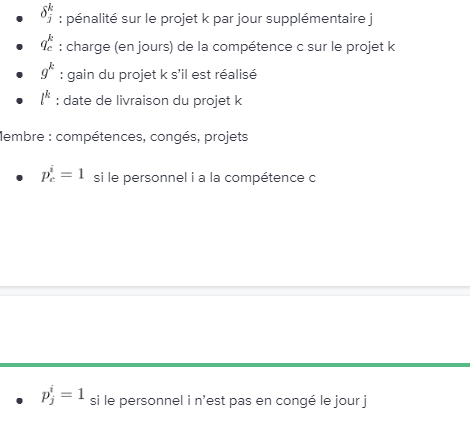

In [5]:
# create a function that converts a dictionary to a matrix
def get_matrix(liste):
    test=pd.DataFrame.from_dict(liste,orient='index')
    test.fillna(0,inplace=True)
    return test.to_dict(orient='index')

In [6]:
# create dictionaries with job_list as key and job_penality, job_gain ans due_dates as values
gammak=job_penality_dict=dict(zip(job_list,job_penality))
gk=job_gain_dict=dict(zip(job_list,job_gain))
lk=due_dates_dict=dict(zip(job_list,due_dates))

# create a dictionary for staff qualifications
pi_c = {}
for i in range(len(staff_names)) :
    k = staff_names[i]
    pi_c[k] = {}
    for c in qualifications:
        if c in data['staff'][i]['qualifications']:
            pi_c[k][c] = 1
        else:
            pi_c[k][c] = 0
qk_c=get_matrix(dict(zip(job_list,job_qualifications)))
# get pi_j
staff_in_vacation=pd.DataFrame(index=staff_names,columns=jour_list)
# fill the dataframe staff_in_vacation with the svalues of the dictionary
for i in staff_names:
    for j in jour_list:
        staff_in_vacation.loc[i,j]=0 if j in dict(zip(staff_names,vacation_staff))[i] else 1
pi_j=staff_in_vacation.to_dict(orient='index')

# Decision variables

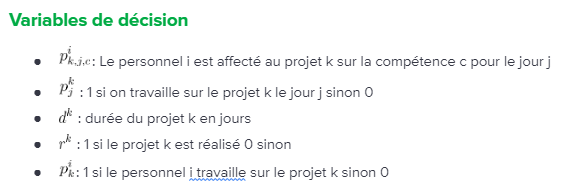

In [7]:
# constraint M1 and M2
M2=horizon*len(staff_names)
M1=horizon*len(qualifications)

In [8]:
# Add decision variables
# pi_k_j_c: Le personnel i est affecté au projet k sur la compétence c pour le jour j
pi_k_j_c = model.addVars(staff_names,job_list,jour_list,qualifications, vtype=GRB.BINARY, name="pi_k_j_c")
# pk_j : 1 si on travaille sur le projet k le jour j sinon 0
#pk_j = model.addVars(job_list,jour_list,vtype=GRB.BINARY, name="pk_j")
# rk : 1 si le projet k est réalisé 0 sinon
rk = model.addVars( job_list,vtype=GRB.BINARY, name="rk")
rk_c = model.addVars(job_list,qualifications,vtype=GRB.BINARY, name="rk_c")
deltak = model.addVars( job_list,vtype=GRB.BINARY, name="deltak")
delta_k_c = model.addVars(job_list,qualifications,vtype=GRB.BINARY, name="delta_k_c")
# pi_k : 1 si le personnel i est affecté au projet k 0 sinon
#pi_k = model.addVars( staff_names,job_list,vtype=GRB.BINARY, name="dk")
model

<gurobi.Model Continuous instance Model: 0 constrs, 0 vars, Parameter changes: Username=(user-defined)>

In [9]:
#Un personnel i peut être associé au projet k que s’il possède la compétence c nécessaire pour le projet :
"""
constr1={'pi_k_j_c':model.addConstr(pi_k_j_c[i,k,j,c]  + (1-pi_c[i][c]) <=1, name="contrainte1")
    for k,j in zip(job_list,jour_list) 
    for i,c in zip(staff_names,qualifications) }
constr2={'pi_k_j_c':model.addConstr(grb.quicksum(pi_k_j_c[i,k,j,c] for k,c in zip(job_list,qualifications)) <=1, name="contrainte2")
    for i,j in zip(staff_names,jour_list)}
constr3={'pi_k_j_c':model.addConstr(pi_k_j_c[i,k,j,c]  + (1-pi_j[i][j]) <=1, name="contrainte3")
    for k,j in zip(job_list,jour_list) 
    for i,c in zip(staff_names,qualifications) }
constr4={'pi_k_j_c':model.addConstr(deltak[f'Job{i+1}'] - (1 - rk[f'Job{i+1}']) <=0, name = "contrainte4")
        for i in range(5)} 
constr5 = {'pi_k_j_c':model.addConstr(grb.quicksum(pi_k_j_c[i,k,j,c] for i,j in zip(staff_names,jour_list)) - qk_c[k][c] + 1 <= 1 - deltak[k] , name = "contrainte5")
        for k in job_list
          for c in qualifications} 
constr6 = {'pi_k_j_c':model.addConstr(grb.quicksum(pi_k_j_c[i,k,j,c] for i,j in zip(staff_names,jour_list)) - qk_c[k][c] + 1 >= -0.99  , name = "contrainte6")
        for k in job_list
          for c in qualifications}
"""

'\nconstr1={\'pi_k_j_c\':model.addConstr(pi_k_j_c[i,k,j,c]  + (1-pi_c[i][c]) <=1, name="contrainte1")\n    for k,j in zip(job_list,jour_list) \n    for i,c in zip(staff_names,qualifications) }\nconstr2={\'pi_k_j_c\':model.addConstr(grb.quicksum(pi_k_j_c[i,k,j,c] for k,c in zip(job_list,qualifications)) <=1, name="contrainte2")\n    for i,j in zip(staff_names,jour_list)}\nconstr3={\'pi_k_j_c\':model.addConstr(pi_k_j_c[i,k,j,c]  + (1-pi_j[i][j]) <=1, name="contrainte3")\n    for k,j in zip(job_list,jour_list) \n    for i,c in zip(staff_names,qualifications) }\nconstr4={\'pi_k_j_c\':model.addConstr(deltak[f\'Job{i+1}\'] - (1 - rk[f\'Job{i+1}\']) <=0, name = "contrainte4")\n        for i in range(5)} \nconstr5 = {\'pi_k_j_c\':model.addConstr(grb.quicksum(pi_k_j_c[i,k,j,c] for i,j in zip(staff_names,jour_list)) - qk_c[k][c] + 1 <= 1 - deltak[k] , name = "contrainte5")\n        for k in job_list\n          for c in qualifications} \nconstr6 = {\'pi_k_j_c\':model.addConstr(grb.quicksum(pi_k_j

# Constraints

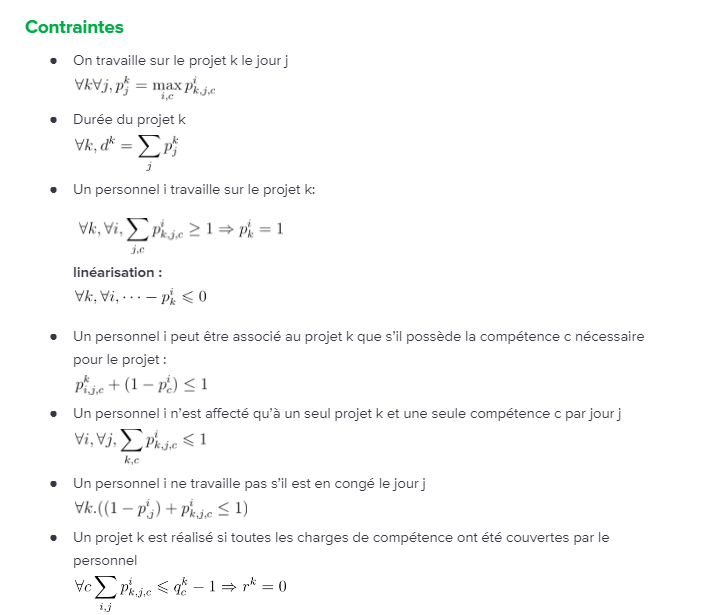

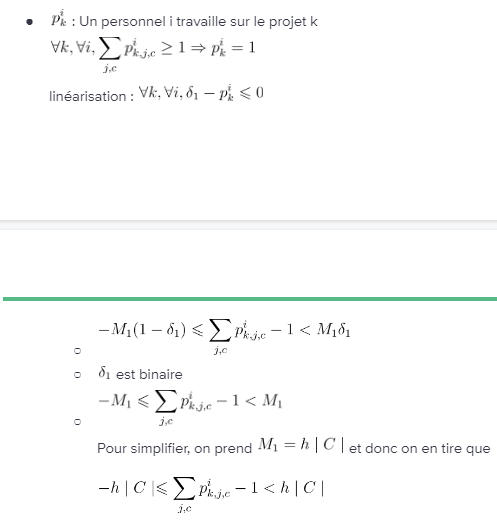

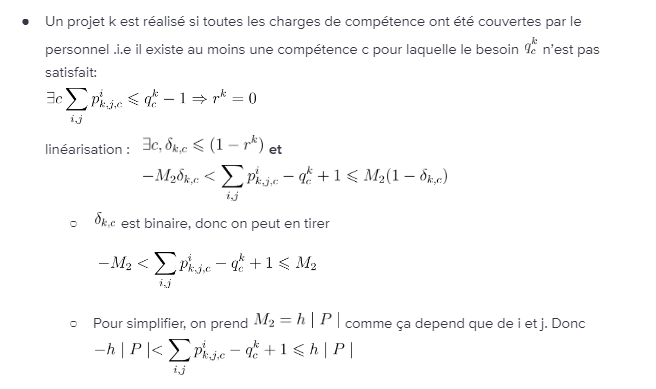

In [37]:
#Un personnel i peut être associé au projet k que s’il possède la compétence c nécessaire pour le projet :
constr1={f'p{i}_{k}_{j}_{c}':model.addConstr(pi_k_j_c[i,k,j,c]  + (1-pi_c[i][c]) <=1, name=f"contrainte1{i}_{k}_{j}_{c}")
    for i in staff_names for k in job_list 
       for j in jour_list  for c in qualifications }
constr2={f'p{i}_{j}':model.addConstr(grb.quicksum(pi_k_j_c[i,k,j,c] for k in job_list for c in qualifications) <=1, name=f"contrainte2{i}_{j}")
    for i in staff_names for j in jour_list}
constr3={f'2p{i}_{k}_{j}_{c}':model.addConstr(pi_k_j_c[i,k,j,c]  + (1-pi_j[i][j]) <=1, name=f"contrainte3{i}_{k}_{j}_{c}")
    for i in staff_names for k in job_list 
       for j in jour_list  for c in qualifications }
constr4={f'p{i}':model.addConstr(delta_k_c[k,c] <= (1 - rk[k]) , name = f"contrainte4{i}")
        for i in range(len(job_list))
        for k in job_list
        for c in qualifications
        } 

constr5 = {f'p{k}_{c}':model.addConstr(grb.quicksum(pi_k_j_c[i,k,j,c] for i in staff_names for j in jour_list) - qk_c[k][c] + 1 <= (1 - delta_k_c[k,c]) , name = f"contrainte5{k}_{c}")
        for k in job_list
          for c in qualifications}

constr6 = {f'p2{k}_{c}':model.addConstr( -delta_k_c[k,c] +0.01<= grb.quicksum(pi_k_j_c[i,k,j,c] for i in staff_names for j in jour_list) - qk_c[k][c] + 1   , name = f"contrainte6{k}_{c}")
        for k in job_list
          for c in qualifications} 
constr7 = {f'p{k}':model.addConstr(deltak[f'Job{i+1}']  >= delta_k_c[f'Job{i+1}',c], name = f"contrainte7{i}")
        for i in range(5)
           for c in qualifications
        }

In [38]:
# Fonction Objectif
model.setObjective(grb.quicksum((job_gain[i]*rk[f'Job{i+1}']) for i in range(5)), GRB.MAXIMIZE)         
# Paramétrage (mode mute)
model.params.outputflag = 0
# Résolution du PL
model.optimize()

In [39]:
#model.computeIIS()
model.write("model.lp")

In [40]:
model.ObjVal

80.0

In [41]:
values= []
for k, v in pi_k_j_c.items():
    values.append(v.x)

In [42]:
res = pd.DataFrame(list(pi_k_j_c.keys()))
res[4] = values
result = res[res[4] == 1]
result

,0,1,2,3,4
19,Olivia,Job2,1,B,1.0
28,Olivia,Job2,4,B,1.0
41,Olivia,Job3,2,C,1.0
53,Olivia,Job3,6,C,1.0
61,Olivia,Job4,3,B,1.0
86,Olivia,Job5,5,C,1.0
96,Liam,Job1,3,A,1.0
106,Liam,Job1,6,B,1.0
117,Liam,Job2,4,A,1.0
138,Liam,Job3,5,A,1.0


## Result Table

In [43]:
def color_table(x):
    if pd.isna(x):
        return "background-color: white"
    else:
        if "Job1" in x :
            return "background-color: blue"
        elif "Job2" in x:
            return "background-color: black"
        elif "Job3" in x:
            return "background-color: orange"
        elif "Job4" in x:
           return "background-color: grey"
        elif "Job5" in x:
           return "background-color: green"
        else:
           return  "background-color: red"

In [44]:
df = pd.DataFrame(columns = [i for i in range(1,6)], index = staff_names)

for ind, val in result.iterrows():
    col = val[2]
    row = val[0]
    v = val[3] + " " + val[1]
    df.loc[row,col] = v
    # vacation
    for staff in staff_names:
        for day in jour_list:
            if pi_j[staff][day] == 0:
                df.loc[staff,day] = 'X'
df.style.applymap(color_table)

,1,2,3,4,5,6
Olivia,B Job2,C Job3,B Job4,B Job2,C Job5,C Job3
Liam,X,B Job4,A Job1,A Job2,A Job3,B Job1
Emma,nan,X,C Job5,C Job4,nan,C Job1


In [51]:
for i in due_dates:
    print(i)

3
3
4
3
5


In [53]:
job_penality_dict

{'Job1': 3, 'Job2': 3, 'Job3': 3, 'Job4': 3, 'Job5': 3}

In [46]:
gk

{'Job1': 20, 'Job2': 15, 'Job3': 15, 'Job4': 20, 'Job5': 10}

In [45]:
job_qualifications

[{'A': 1, 'B': 1, 'C': 1},
 {'A': 1, 'B': 2},
 {'A': 1, 'C': 2},
 {'B': 2, 'C': 1},
 {'C': 2}]

In [47]:
staff_qualifications

[['A', 'B', 'C'], ['A', 'B'], ['C']]

In [19]:
delta_k_c

{('Job1', 'A'): <gurobi.Var delta_k_c[Job1,A] (value 0.0)>,
 ('Job1', 'B'): <gurobi.Var delta_k_c[Job1,B] (value 0.0)>,
 ('Job1', 'C'): <gurobi.Var delta_k_c[Job1,C] (value 0.0)>,
 ('Job2', 'A'): <gurobi.Var delta_k_c[Job2,A] (value 0.0)>,
 ('Job2', 'B'): <gurobi.Var delta_k_c[Job2,B] (value 0.0)>,
 ('Job2', 'C'): <gurobi.Var delta_k_c[Job2,C] (value 0.0)>,
 ('Job3', 'A'): <gurobi.Var delta_k_c[Job3,A] (value 0.0)>,
 ('Job3', 'B'): <gurobi.Var delta_k_c[Job3,B] (value 0.0)>,
 ('Job3', 'C'): <gurobi.Var delta_k_c[Job3,C] (value 0.0)>,
 ('Job4', 'A'): <gurobi.Var delta_k_c[Job4,A] (value 0.0)>,
 ('Job4', 'B'): <gurobi.Var delta_k_c[Job4,B] (value 0.0)>,
 ('Job4', 'C'): <gurobi.Var delta_k_c[Job4,C] (value 0.0)>,
 ('Job5', 'A'): <gurobi.Var delta_k_c[Job5,A] (value 0.0)>,
 ('Job5', 'B'): <gurobi.Var delta_k_c[Job5,B] (value 0.0)>,
 ('Job5', 'C'): <gurobi.Var delta_k_c[Job5,C] (value 0.0)>}

In [20]:
rk

{'Job1': <gurobi.Var rk[Job1] (value 1.0)>,
 'Job2': <gurobi.Var rk[Job2] (value 1.0)>,
 'Job3': <gurobi.Var rk[Job3] (value 1.0)>,
 'Job4': <gurobi.Var rk[Job4] (value 1.0)>,
 'Job5': <gurobi.Var rk[Job5] (value 1.0)>}